## Neural Network

In [14]:
import sys
sys.path.append('../../')

# Import libraries
from utils.load import load
from utils.score import fold_cross_validate, visualize_classification_result, visualize_feature_importance
from utils.print import print_cross_validation_scores, print_scores
from constant.columns import FEATURES, LABEL

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean, std
import keras as keras
from keras import activations, backend as K
from keras.wrappers import scikit_learn
from keras.models import Sequential
from keras.layers import Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from eli5.sklearn import PermutationImportance

In [15]:
# Import data
df = pd.read_csv('./source/dataset.csv')
X, y = df[FEATURES], df[LABEL]

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False)

#### Cross Validation

In [16]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Define a sklearn-compatible classifier based on our Keras model
class KerasBinaryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        self.model.fit(X, y, epochs=150, batch_size=10, verbose=0)
        return self
    def predict(self, X):
        Y_pred = self.model.predict(X)
        Y_pred = (Y_pred >= 0.5).astype(int)
        return Y_pred.flatten()

def create_model():
    model = Sequential()
    model.add(Dense(6, input_dim=len(FEATURES), activation=activations.relu))
    model.add(Dense(1, activation=activations.sigmoid))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [17]:
# Define the model
clf_cv = scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)
scores = fold_cross_validate(clf_cv, X, y)

# Print scores
print_cross_validation_scores(scores)

C:\Users\dell\AppData\Local\Temp\ipykernel_18132\2537990511.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf_cv = scikit_learn.KerasClassifier(build_fn=create_model, epochs=100, batch_size=32, verbose=0)


MACRO:
Precision: 0.5495 (0.1336)
Recall: 0.5421 (0.0744)
F1 score: 0.5281 (0.0744)
---------------------------------
MICRO:
Precision: 0.9213 (0.0667)
Recall: 0.9213 (0.0667)
F1 score: 0.9213 (0.0667)


#### Feature Importance

C:\Users\dell\AppData\Local\Temp\ipykernel_18132\3001705512.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = keras.wrappers.scikit_learn.KerasClassifier(


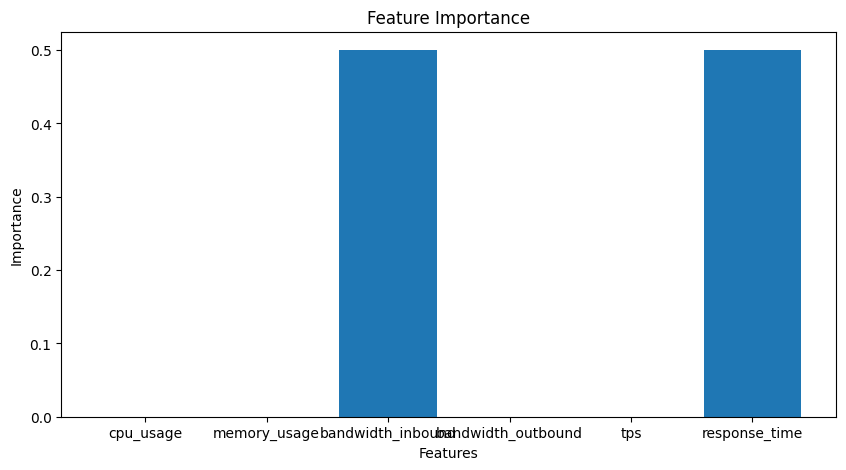

In [18]:
# Create model
clf = keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=create_model, epochs=100, batch_size=32, verbose=0)
clf.fit(X_train, y_train)

# Create a Permutation Importance object
perm = PermutationImportance(clf, random_state=1).fit(X_train, y_train)

# Get feature importances
importances = perm.feature_importances_

# Normalize the importances
normalized_importances = importances / np.sum(importances)
visualize_feature_importance(normalized_importances, FEATURES)

### Train the model

In [19]:
# Define the model
clf = keras.wrappers.scikit_learn.KerasClassifier(
    build_fn=create_model, epochs=100, batch_size=32, verbose=0)

# Train the model
clf.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

C:\Users\dell\AppData\Local\Temp\ipykernel_18132\195081513.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  clf = keras.wrappers.scikit_learn.KerasClassifier(


Epoch 1/150
120/120 [==============================] - 1s 2ms/step - loss: 181.6681 - accuracy: 0.9408
Epoch 2/150
120/120 [==============================] - 0s 2ms/step - loss: 83.5033 - accuracy: 0.9425
Epoch 3/150
120/120 [==============================] - 0s 2ms/step - loss: 27.8511 - accuracy: 0.9300
Epoch 4/150
120/120 [==============================] - 0s 1ms/step - loss: 23.3112 - accuracy: 0.9217
Epoch 5/150
120/120 [==============================] - 0s 2ms/step - loss: 13.4487 - accuracy: 0.9167
Epoch 6/150
120/120 [==============================] - 0s 2ms/step - loss: 12.3185 - accuracy: 0.9083
Epoch 7/150
120/120 [==============================] - 0s 1ms/step - loss: 8.9990 - accuracy: 0.9025
Epoch 8/150
120/120 [==============================] - 0s 2ms/step - loss: 8.4400 - accuracy: 0.9100
Epoch 9/150
120/120 [==============================] - 0s 2ms/step - loss: 7.3597 - accuracy: 0.9042
Epoch 10/150
120/120 [==============================] - 0s 2ms/step - loss: 6.8115 -

In [20]:
# Use the model to make predictions on the test set
y_pred = clf.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]  # threshold

# Print scores
print_scores(y_test, y_pred)

10/10 [==============================] - 0s 1ms/step
Accuracy: 0.7966666666666666
Precision: 0.2597402597402597
Recall: 0.8333333333333334
F1: 0.39603960396039606


### Visualize the model

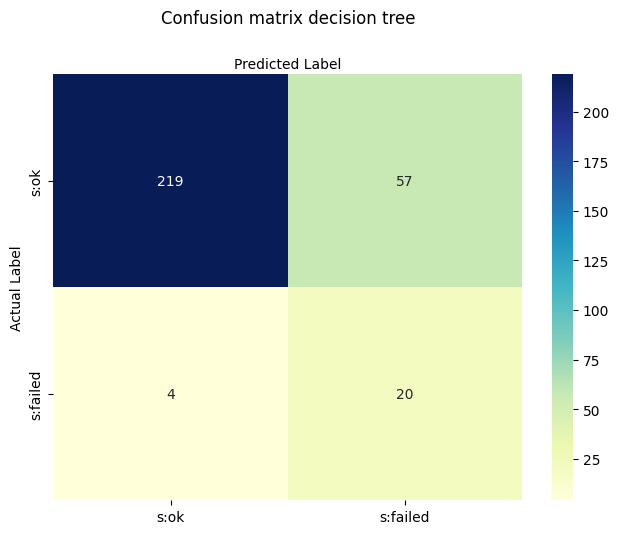

In [21]:
visualize_classification_result(y_test, y_pred)